<center>
<h1>Midterm 2 (solo)</h1>
</center>

I'd like you to try out Naive Bayes on the tweet problem, the same one you worked on in the first midterm.

<hr>

#Bring in uo_puddles library

In [0]:
#flush the old directory
!rm -r  'uo_puddles'

In [0]:
my_github_name = 'uo-puddles'

In [0]:
clone_url = f'https://github.com/{my_github_name}/uo_puddles.git'

In [0]:
#this adds the library to colab so you can now import it
!git clone $clone_url  


Cloning into 'uo_puddles'...
remote: Enumerating objects: 231, done.
remote: Counting objects: 100% (231/231), done.
remote: Compressing objects: 100% (195/195), done.
remote: Total 231 (delta 137), reused 64 (delta 33), pack-reused 0
Receiving objects: 100% (231/231), 58.17 KiB | 684.00 KiB/s, done.
Resolving deltas: 100% (137/137), done.


In [0]:
import uo_puddles.uo_puddles as up 


# Bring in the tweet dataset. Same as you used in midterm 1.

In [0]:
import pandas as pd
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vRpZtv1ZFa7Am4j7U8S4JDYTuGkAp3rEyVh7riN8nVLEcaos_wgoAyJiRiE1oe8aITeex8BG-z6Sj5-/pub?output=csv'
tweet_table = pd.read_csv(url) 

In [0]:
pd.set_option('display.max_columns', None)

In [0]:
tweet_table.head()

,author,text
0,0,@user when a father is dysfunctional and is so...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [0]:
len(tweet_table)  #32K tweets!

31962

<h2>How are the 2 classes distributed?</h2>

It is useful to know what percentage of the 30K tweets are hateful. pandas gives me a way to count the different values in a column. Check it out.

In [0]:
tweet_table['author'].value_counts()

0    29720
1     2242
Name: author, dtype: int64

In [0]:
tweet_table['author'].value_counts()/len(tweet_table)

0    0.929854
1    0.070146
Name: author, dtype: float64

Uh, that is a low percentage. So if we guess a tweet is non-hateful (i.e., has author 0) we will be correct 93% of the time. Going to be hard to beat.

#Bring in spacy

In [0]:
import spacy

In [0]:
#you first have to get colab to download it locally

!python -m spacy download en_core_web_md

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [0]:
#now you can import the dictionary and set up a parser

import en_core_web_md
nlp = en_core_web_md.load()

#Step 1

Shuffle main table and create training and testing tables.

Use 9589 as your cut point, roughly .3 for testing and .7 for training.

In [0]:
our_seed = 1234  #if we all use this we should get same random data

In [0]:
import numpy as np  #powerful library for manipulating data
rsgen = np.random.RandomState(our_seed)  #we are only going to use numpy's random number generator for now

In [0]:
#your code
shuffled_table = tweet_table.sample(frac=1, random_state=rsgen).reset_index(drop=True)


In [0]:
shuffled_table.head()

,author,text
0,0,nove :) #flylondon #friends #sunglasses #love
1,0,can't wait anymore ! ðð only a day left ...
2,0,i am thankful for passion. #thankful #positive
3,0,blending with nature&gt;&gt;link in bio#shoot2...
4,0,@user tragic. #wolves


Create testing_table.

In [0]:
#your code
testing_table = shuffled_table[:9589].reset_index(drop=True)

Make sure you match my testing table.

<img src='https://www.dropbox.com/s/6iq8emxhqqe2blx/Screenshot%202020-04-14%2012.02.27.png?raw=1'>

In [0]:
testing_table.head()

,author,text
0,0,nove :) #flylondon #friends #sunglasses #love
1,0,can't wait anymore ! ðð only a day left ...
2,0,i am thankful for passion. #thankful #positive
3,0,blending with nature&gt;&gt;link in bio#shoot2...
4,0,@user tragic. #wolves


Create training_table.

In [0]:
#your code
training_table = shuffled_table[9589:].reset_index(drop=True)


Make sure you match mine.

<img src='https://www.dropbox.com/s/a5hiq4j8mzl0aal/Screenshot%202020-04-14%2012.04.40.png?raw=1'>

In [0]:
training_table.head()

,author,text
0,0,the young are grossly misinformed...the media ...
1,0,#pakistan. i am that cyber crime bill has no...
2,0,bihdayfemikuti great man from great family #gr...
3,0,@user seems the national post finds this to be...
4,0,"@user ok, here goes, i have been accepted to ..."


#The training table is big

But given that NB is faster than KNN, we can use the whole table and not have to trim it.

In [0]:
len(training_table)  #22373

22373

#Step 2.

Pull the columns out of each table to end up with these:

* training_text. A python list of the tweets in training_table.

* training_authors. A python list of the authors in training_table.

* testing_text. A python list of the tweets in testing_table.

* testing_authors. A python list of the authors in testing_table.

In [0]:
training_text = training_table['text'].to_list()
training_text[:5]

['the young are grossly misinformed...the media projects negative energy and music and movies make u believe its cool to tun up #lost',
 '#pakistan. i am   that cyber crime bill has not passed yet and i can #share it in #respect of #nawazsharif',
 'bihdayfemikuti great man from great family #greatlegendreyfamily #longlive #femikuti  #bihday #greatfamily',
 '@user seems the national post finds this to be a more better story than the victims of the war... np get your ð\x9f\x92©  together #poop',
 ' @user ok, here goes, i have been accepted to speak at a conference in the usofa later in the year   #suffolkhour :) ']

In [0]:
#your code
training_labels = training_table['author'].to_list()

In [0]:
print(training_labels[:30])  #[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1]


In [0]:
testing_text = testing_table['text'].to_list()
testing_text[:5]

['nove :) #flylondon #friends   #sunglasses #love',
 "can't wait anymore ! ð\x9f\x98\x86ð\x9f\x98\x9c only a day left ! ð\x9f\x98\x98ð\x9f\x98\x8d @user ð\x9f\x98\x98 well nt even tht ! it's 22 hrs 46 mins still !  ð\x9f\x99\x88 can't control me now  ð\x9f\x92\x93",
 'i am thankful for passion. #thankful #positive',
 'blending with nature&gt;&gt;link in bio#shoot2kill #illgrammers #nature #fashion #outdoors  â\x80¦',
 '@user tragic.   #wolves']

In [0]:
testing_labels = testing_table['author'].to_list()

In [0]:
print(testing_labels[:30])  #[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


#Step 3.

<img src='https://www.dropbox.com/s/3uyvp722kp5to2r/assignment.png?raw=1' width='300'>

I think you are good to go. Build word_bag using the `training_text` and `training_authors` lists. Use a conditional to make sure you only include alpha words and non-stop-words.

Warning: this took me 5 minutes of wall-time to compute.

I'll try to get you started. Below is the "new list" we are building. But it is a table, not a list. And instead of appending, you will use the `up.update_gothic_row` function.

Note that column names are now the ints 0 and 1. Reminder: author 0 is the non-hateful category and author 1 is the hateful category.

Also, here is a new puddles function you can use to update the table. Works the same as update_gothic_row.

In [0]:
word_table = pd.DataFrame(columns=['word', 0, 1])  #this is the "new list", actually a table
word_table

,word,0,1


In [0]:
up.update_tweet_row(word_table, 'indefinite', 1)

,word,0,1
0,indefinite,0,1


Took me 7 minutes to build the word_table.

In [0]:
#your code
%%time

word_table = pd.DataFrame(columns=['word', 0, 1])

for i in range(len(training_text)):
  doc = nlp(training_text[i].lower())
  for token in doc:
    if token.is_alpha and not token.is_stop:
      up.update_tweet_row(word_table, token.text, training_labels[i])

CPU times: user 7min 56s, sys: 1.5 s, total: 7min 57s
Wall time: 7min 58s


In [0]:
training_labels[:5]

[0, 0, 0, 0, 0]

In [0]:
len(word_table)  #28086 words. 7K more than gothic authors used.

28086

In [0]:
word_table.head()
  

,word,0,1
0,young,93,4
1,grossly,2,0
2,misinformed,1,0
3,media,53,21
4,projects,6,0


Match mine:

<img src='https://www.dropbox.com/s/jkbki6gvg014ysm/Screenshot%202020-05-05%2015.50.23.png?raw=1' height=200>

In [0]:
word_table.tail()

,word,0,1
28081,malicious,1,0
28082,championships,1,0
28083,masutanicouple,1,0
28084,nighter,1,0
28085,supernaturalfest,1,0


Match mine:

<img src='https://www.dropbox.com/s/ytydnq05ib9zev0/Screenshot%202020-05-05%2015.51.01.png?raw=1' height=200>

#Step 4.

Sort on word.


In [0]:
#your code
sorted_word_table = word_table.sort_values(by=['word']).reset_index(drop=True)

In [0]:
sorted_word_table.head()

,word,0,1
0,aaa,2,0
1,aaaaaand,1,0
2,aaahhhh,1,0
3,aaahhhhh,1,0
4,aaawwwww,1,0


Match mine:

<img src='https://www.dropbox.com/s/ra1tko7ljnljrn3/Screenshot%202020-05-05%2015.51.40.png?raw=1'>

#Step 5.

Make the word column the new index column.


In [0]:
#your code
sorted_word_table = sorted_word_table.set_index('word')


In [0]:
sorted_word_table.head()

,0,1
word,,
aaa,2,0
aaaaaand,1,0
aaahhhh,1,0
aaahhhhh,1,0
aaawwwww,1,0


Match mine:

<img src='https://www.dropbox.com/s/mph0byyk4u8s8fp/Screenshot%202020-05-05%2015.52.48.png?raw=1'>

#Write it out!

Don't want to have to keep building the bag everytime you restart this notebook.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
with open('/content/gdrive/My Drive/Course Work/CIS510/tweet_bag_s20.csv', 'w') as file:
    sorted_word_table.to_csv(file, index=True)

##Please use url to read it back in

You know there are 2 ways to read it back in. But the only way I can run your notebook is if you read back using url. So please use that way. Grab url from Google Sheets and paste in below.


In [0]:
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vRKEg9mkcbnELjwIxkZHENhG74Sqs-E1LwxMnpDOEJ9YeXoifd70d4jxVIzYnqN4NGITuxEVnMwO3NK/pub?output=csv'  #paste your url here

In [0]:
sorted_word_table = pd.read_csv(url, dtype={'word':str}, encoding='utf-8',
                                index_col='word', na_filter=False)
sorted_word_table = sorted_word_table.rename(index={'TRUE': 'true', 'FALSE': 'false'}) #need this because of bug in reading from url

In [0]:
sorted_word_table.head()

,0,1
word,,
aaa,2,0
aaaaaand,1,0
aaahhhh,1,0
aaahhhhh,1,0
aaawwwww,1,0


#Step 6.

I am giving you the equivalent of bayes_gothic. New puddles function is called bayes_tweet. Works the same as bayes_gothic. It produces a list of values, but only 2 this time; we only have 2 authors.

Go ahead and use it to produce a list of pairs called `result_list`.

In [0]:
up.bayes_tweet(['media'], sorted_word_table, training_table)  #(0.0006422296090321772, 6.585456154064723e-05)

(0.0010262950860910817, 5.2873515176483295e-05)

In [0]:
sorted_word_table.loc['media']

0    53
1    21
Name: media, dtype: object

In [0]:
sorted_word_table.loc['media']

0    53
1    21
Name: media, dtype: object

In [0]:
%%time

#your code
result_list = []
for i in range(len(testing_text)):
  doc = nlp(testing_text[i].lower())
  
  e_list = []
  for token in doc:
    if token.is_alpha and not token.is_stop:
      e_list.append(token.text)

  result_list.append(up.bayes_tweet(e_list, sorted_word_table, training_table))


CPU times: user 3min, sys: 125 ms, total: 3min
Wall time: 3min


In [0]:
result_list[:5]

[(2.137516608768707e-17, 3.096298772803711e-22),
 (1.1788667243745258e-26, 4.289033845647874e-36),
 (6.587850794430615e-08, 8.183713875166037e-15),
 (2.459648707899393e-19, 6.192597545607422e-24),
 (2.7226787528538115e-08, 8.096966508089277e-11)]

<pre>
[(1.13701053140327e-17, 1.2126976868876875e-21),
 (4.620940542069699e-29, 1.1810918673576957e-36),
 (1.1453358172342027e-08, 1.1423350301467696e-14),
 (2.269985532970149e-20, 6.737209371598264e-23),
 (3.0222693510234466e-08, 2.1036099580152762e-10)]
 </pre>

#Step 7.

Now produce predictions. Should be a list of 0s and 1s.

In [0]:
#your code
predictions = []
for i in range(len(result_list)):
  probs = result_list[i]
  max_prob = max(probs)
  prediction = 0
  if probs.index(max_prob)==1:
    prediction = 1
  predictions.append(prediction)
  

In [0]:
predictions[:20]  #[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [0]:
testing_labels[:20]  #reminder of where the "answers" are

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

#Step 8.

Go ahead and compute accuracy. I got `0.9497340702888727`.

In [0]:
#your code
zipped = list(zip(predictions, testing_labels))
(zipped.count((0,0)) + zipped.count((1,1)))/len(testing_labels)

0.9490040671602878

Here is what we want to beat.

In [0]:
testing_labels.count(0)/len(testing_labels)  #0.9326311398477422

0.9326311398477422

Here is heat-map visualization of the 4 cases. You will need a zipped version to use this.

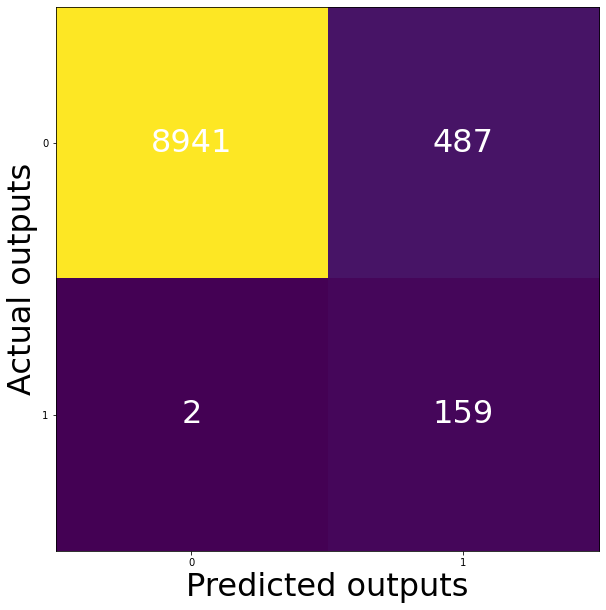

In [0]:
up.heat_map(zipped, [0,1])

#Discussion

I'm kind of impressed. We almost bumped accuracy 2 percentage points from just always choosing 0. May not seem like much. But once we get into the 90s, I don't expect to see dramatic jumps. I'd claim that running NB on this problem is worth it.

From a cost perspective, we only let through 40 false-negatives. So only 40 hateful tweets slipped past us. That will make those that are trying to clean up social media happy.

We did also have 442 false-positives, tweets we labeled as hateful but were not. That would not make those who champion free-speech happy.